This is a Keras Implementation of Pong specifically designed for the colaboratory environment, using reinforcement learning. Written by Yijie Xu, for the GradientCrescent publication. 

In [0]:
#

#Visualization cobe for running within Colab




# Install dependencies first for graphics visualization within Colaboratory

#remove " > /dev/null 2>&1" to see what is going on under the hood
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1



     |████████████████████████████████| 583kB 2.3MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: setuptools 41.2.0
    Uninstalling setuptools-41.2.0:
      Successfully uninstalled setuptools-41.2.0


Consult https://github.com/thinkingparticle/deep_rl_pong_keras/blob/master/reinforcement_learning_pong_keras_policy_gradients.ipynb 

Especially for running visualization

In [0]:

import numpy as np
import gym

# gym initialization
env = gym.make("Pong-v0")
observation = env.reset()
prev_input = None

# Declaring the two actions that can happen in Pong for an agent, move up or move down
# Decalring 0 means staying still. Note that this is pre-defined specific to package.
UP_ACTION = 2
DOWN_ACTION = 3

# Hyperparameters. Gamma here allows you to measure the effect of future events
gamma = 0.99

# initialization of variables used in the main loop
x_train, y_train, rewards = [],[],[]
reward_sum = 0
episode_nb = 0

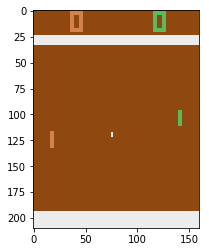

In [0]:
#Let's take a look at the game in action.


import tensorflow as tf
import matplotlib.pyplot as plt


env = gym.make("Pong-v0") # environment info
observation = env.reset()
# The ball is released after 20 frames
for i in range(22):
  
  if i > 20:
    plt.imshow(observation)
    plt.show()

  observation, _, _, _ = env.step(1)
  
  
  
  #Can plot more later



In [0]:
#Preprocessing function


def prepro(I):
  """ prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector """
  I = I[35:195] # crop
  I = I[::2,::2,0] # downsample by factor of 2
  I[I == 144] = 0 # erase background (background type 1)
  I[I == 109] = 0 # erase background (background type 2)
  I[I != 0] = 1 # everything else (paddles, ball) just set to 1
  return I.astype(np.float).ravel()




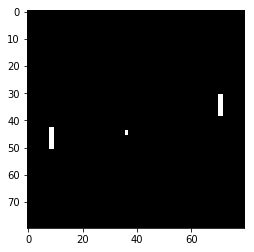

In [0]:
#Show preprocessed

obs_preprocessed = prepro(observation).reshape(80,80)
plt.imshow(obs_preprocessed, cmap='gray')
plt.show()

Original Floyd Approach at https://blog.floydhub.com/spinning-up-with-deep-reinforcement-learning/

Also consider https://github.com/mrahtz/tensorflow-rl-pong/blob/master/pong.py



In [0]:
#Karpathy Suport class


# reward discount used by Karpathy (cf. https://gist.github.com/karpathy/a4166c7fe253700972fcbc77e4ea32c5)
def discount_rewards(r, gamma):
  """ take 1D float array of rewards and compute discounted reward """
  r = np.array(r)
  discounted_r = np.zeros_like(r)
  running_add = 0
  # we go from last reward to first one so we don't have to do exponentiations
  for t in reversed(range(0, r.size)):
    if r[t] != 0: running_add = 0 # if the game ended (in Pong), reset the reward sum
    running_add = running_add * gamma + r[t] # the point here is to use Horner's method to compute those rewards efficiently
    discounted_r[t] = running_add
  discounted_r -= np.mean(discounted_r) #normalizing the result
  discounted_r /= np.std(discounted_r) #idem using standar deviation
  return discounted_r


"""
The function works thusly: negative rewards are spread to the frames before our model missed the ball (before the -1.0 in reward), idem for the positive.

Essentially, we set the reward of actions taken before each reward, similar to the reward obtained.

for example if we got reward +1 at time 200, we say that reward of time 199 is +0.99, reward of time 198 is +0.98 and so on.

But note that the list created will have all 21 points of interactions done. So you have multiple lives here within a single term. Have to work out how this method works exactly
"""

'\nThe function works thusly: negative rewards are spread to the frames before our model missed the ball (before the -1.0 in reward), idem for the positive.\n\nEssentially, we set the reward of actions taken before each reward, similar to the reward obtained.\n\nfor example if we got reward +1 at time 200, we say that reward of time 199 is +0.99, reward of time 198 is +0.98 and so on.\n\nBut note that the list created will have all 21 points of interactions done. So you have multiple lives here within a single term. Have to work out how this method works exactly\n'

In [0]:
# import necessary modules from keras
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.models import Sequential
import keras
from keras.models import InputLayer
from keras.optimizers import Adam

# creates a generic neural network architecture

"""
The 80 * 80 input dimension comes from the pre-processing of the raw pixels made by Karpathy (the only important pixels are the balls and the paddle)
Input here represents the difference in pixels betewen one frame and another, giving you direction of agents and ball. Encoded in Karpathy's own preprocessing functions

TODO, try adding a 400 layer infront of the 200 unit layer
"""


model = Sequential()

# hidden layer takes a pre-processed frame as input, and has 200 units. Simple layer architectur of 200 x1, 1x1
model.add(Dense(units=200,input_dim=80*80, activation='relu', kernel_initializer='glorot_uniform'))

# output layer - we use a Sigmoid here, in order to get a 0, or 1 value to represent ACTION UP
model.add(Dense(units=1, activation='sigmoid', kernel_initializer='RandomNormal'))

# compile the model using traditional Machine Learning losses and optimizers
model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])
print(model.summary())










Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200)               1280200   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 201       
Total params: 1,280,401
Trainable params: 1,280,401
Non-trainable params: 0
_________________________________________________________________
None


Using TensorFlow backend.


"\ninputs = keras.layers.Input(shape=(80,80))\nchanneled_input = keras.layers.Reshape((80,80,1))(inputs) # Conv2D requries (batch, height, width, channels)  so we need to create a dummy channel \nconv_1 = keras.layers.Conv2D(filters=10,kernel_size=20,padding='valid',activation='relu',strides=(4,4),use_bias=False)(channeled_input)\nconv_2 = keras.layers.Conv2D(filters=20,kernel_size=10,padding='valid',activation='relu',strides=(2,2),use_bias=False)(conv_1)\nconv_3 = keras.layers.Conv2D(filters=40,kernel_size=3,padding='valid',activation='relu',use_bias=False)(conv_2)\nflattened_layer = keras.layers.Flatten()(conv_3)\nsigmoid_output = keras.layers.Dense(1,activation='sigmoid',use_bias=False)(flattened_layer)\nmodel = keras.models.Model(inputs=inputs,outputs=sigmoid_output)\nmodel.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])\nprint(model.summary())\n"

In [8]:
history = []
observation = env.reset()
prev_input = None
# main training loop
while (True):

    """
    Start by preprocessing the observation frame, and then doing the difference with the previous frame. Naturally if frame 1 then we subtract by zeros
    
    X here is the frame-frame difference, Y is the next action (kind of like an RNN). We are trying to predict the next action given two observations.
    """
    cur_input = prepro(observation)
    #print(len(cur_input)) - Sanity Check reasons only
    
    x = cur_input - prev_input if prev_input is not None else np.zeros(80 * 80)
    prev_input = cur_input
    
    # forward the policy network and sample action according to the probability distribution
    """
    Running model.predict to know what the current model thinks about the probability of doing the UP_ACTION, given the current frame setting.
    
    Double check size and shape of the array here im pretty sure its for bias term?
    Keras requires a third?? dimension perhaps hre
    """
    
    
    proba = model.predict(np.expand_dims(x, axis=1).T)
    # proba=model.predict(np.expand_dims(x.reshape(80,80), axis=0)) 2D model stuff DELETE
    
    
    #Intorucing another probability distirubtion here, not sure
    action = UP_ACTION if np.random.uniform() < proba else DOWN_ACTION
    y = 1 if action == 2 else 0 # 0 and 1 are our labels

    # log the input and label to train later
    x_train.append(x)
    y_train.append(y)

    # do one step in our environment - This is returned by our environment in OpenAI gym.  
    observation, reward, done, info = env.step(action)
    #Note how AT EACH STEP A REWARD IS CALCULATED. THIS IS NOT EACH GAME BUT EACH FRAME-FRAME DIFFERENCE.  MOST OF THE TIME THIS IS 0
    #THESE REWARDS ARE USED TO ENCOURAGE OR DISCOURAGE MOVEMENTS
    rewards.append(reward)
    reward_sum += reward
    
    """
    rewards : to each frame (x_train[frame_number]) and action (y_train[frame_number]) 
    is associated a reward (-1 if it missed the ball, 0 if nothing happens, and 1 if opponent misses the ball), so we get for instance the following array:
    """
    
    # end of an episode - The GYM also invokes DONE automatically. Invoked when one player reaches 21
    if done:
        
        history.append(reward_sum)
        print('At the end of episode', episode_nb, 'the total reward was :', reward_sum)
        if episode_nb>=3000 and reward_sum >=-12:
          break
        else:
          
        
          # increment episode number
          episode_nb += 1
        
          # training
          model.fit(x=np.vstack(x_train), y=np.vstack(y_train), verbose=1, sample_weight=discount_rewards(rewards, gamma))
        
          """
          If an action leads to a positive reward, it tunes the weights of the neural network so it keeps on predicting this winning action.
          Otherwise, it tunes them in the opposite way


          The function discount_rewards transforms the list of rewards so that even actions that remotely lead to positive rewards are encouraged. THIS IS IMPORTANT
          OTHERWISE WE WOULD SIMPLY BE TRYING TO REPLICATE RANDOM MOVEMENTS

          sample_weights is used to provide a weight for each training sample. 
          That means that you should pass a 1D array with the same number of elements as your training samples (indicating the weight for each of those samples. NOTE THIS IS NOT CLASS WEIGHTS
          """
                                                             
          # Reinitialization
          x_train, y_train, rewards = [],[],[]
          observation = env.reset()
          reward_sum = 0
          prev_input = None







At the end of episode 0 the total reward was : -21.0


Epoch 1/1
1262/1262 [==============================] - 2s 1ms/step - loss: 1.9322e-04 - acc: 0.5246
At the end of episode 1 the total reward was : -21.0
Epoch 1/1
1084/1084 [==============================] - 1s 877us/step - loss: -0.0087 - acc: 0.5378
At the end of episode 2 the total reward was : -21.0
Epoch 1/1
1118/1118 [==============================] - 1s 879us/step - loss: 0.0019 - acc: 0.5859
At the end of episode 3 the total reward was : -21.0
Epoch 1/1
1104/1104 [==============================] - 1s 897us/step - loss: -0.0160 - acc: 0.5679
At the end of episode 4 the total reward was : -21.0
Epoch 1/1
1110/1110 [==============================] - 1s 903us/step - loss: -0.0097 - acc: 0.6261
At the end of episode 5 the total reward was : -21.0
Epoch 1/1
1175/1175 [==============================] - 1s 895us/step - loss: 0.0171 - acc: 0.6698
At the end of episode 6 the total reward was : -20.0
Epoch 1/1
1314/1314 [=======

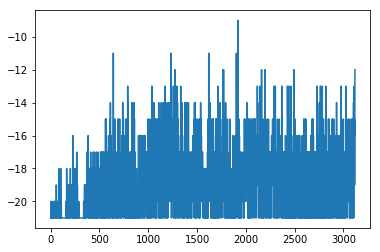

In [9]:
#Plot results - remember to call keyboard interrupt before this

plt.plot(history)
plt.show()

In [10]:
#To Evaluate model on OpenAI gym, we will record a video via Ipython display


import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay


from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

In [0]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

In [12]:
#Evaluate model on openAi GYM

#To do this consult https://github.com/thinkingparticle/deep_rl_pong_keras/blob/master/reinforcement_learning_pong_keras_policy_gradients.ipynb
env = wrap_env(gym.make('Pong-v0'))
observation = env.reset()
new_observation = observation
prev_input = None
done = False
while True:
  if True: 
    
    #set input to network to be difference image
  
    cur_input = prepro(observation)
    x = cur_input - prev_input if prev_input is not None else np.zeros(80 * 80)
    prev_input = cur_input
  
    # Sample an action (policy)
    proba = model.predict(np.expand_dims(x, axis=1).T)
    action = UP_ACTION if np.random.uniform() < proba else DOWN_ACTION
        
    env.render()
    # Return action to environment and extract
    #next observation, reward, and status
    observation = new_observation
    new_observation, reward, done, info = env.step(action)
    if done: 
      #observation = env.reset()
      break
      
env.close()
show_video()